###Please Cite this: Banerjee, Anasua, and Debajyoty Banik. "Pooled hybrid-spectral for hyperspectral image classification." Multimedia Tools and Applications 82.7 (2023): 10887-10899.

#To have an access from gmail account to any dataset which is already uploaded therein we need this code section which is shown below.

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
down = drive.CreateFile({'id':'1fZLfCu20II0zUjIGDOW2IuqXcssgdAQb'}) #Unique ID which we got from the google drive
down.GetContentFile('KSC.mat')
downs = drive.CreateFile({'id':'1fhDhiR6YvLdXrzlOSZ_XJp7QzBIpsFvn'})
downs.GetContentFile('KSC_gt.mat')

In [ ]:
%load_ext tensorboard
import datetime, os
!pip install -q keras
!pip install h5py ppyaml
!pip install spectral
import spectral
import scipy.io as sio
from scipy.io import loadmat
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import seaborn as sn
import keras
from sklearn.utils import class_weight
from keras import backend as A
from keras.backend import sigmoid
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.layers import BatchNormalization,Dense, Dropout, Activation, Flatten, Conv2D , Conv3D,ConvLSTM2D,MaxPooling2D, Reshape,Input,MaxPooling3D,LSTM
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils.generic_utils import get_custom_objects
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

ERROR: Could not find a version that satisfies the requirement ppyaml (from versions: none)
ERROR: No matching distribution found for ppyaml
     |████████████████████████████████| 184kB 4.9MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212938 sha256=e6b7a2dcb87e1d84d684fc873ea9a4c3c320f6be6f176eac62f30ca468ef376f
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


#We have to import more libraries so that our work become sucessful

In [ ]:
original = loadmat('KSC.mat')
ground= loadmat('KSC_gt.mat')
print(original.keys())
print(ground.keys())

dict_keys(['__header__', '__version__', '__globals__', 'KSC'])
dict_keys(['__header__', '__version__', '__globals__', 'KSC_gt'])


In [ ]:
original['KSC'].shape
ground['KSC_gt'].shape

(512, 614)



#Define some fuctions like split of training testing ratio, dimension reduction technique and creating image cubes all these is shown below blocks cosecutively.

In [ ]:
def ImageCube(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesoriginal = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesground = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesoriginal[patchIndex, :, :, :] = patch
            patchesground[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesoriginal = patchesoriginal[patchesground>0,:,:,:]
        patchesground = patchesground[patchesground>0]
        patchesground -= 1
    return patchesoriginal, patchesground

In [ ]:
def padWithZeros(X, margin=2):
    newpad = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newpad[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newpad

In [ ]:
from sklearn.decomposition import PCA
def applyPCA(X, numComponents=75):
   newpad = np.reshape(X, (-1, X.shape[2]))
   pca = PCA(n_components=numComponents, whiten=True)
   newpad = pca.fit_transform(newpad)
   newpad= np.reshape(newpad, (X.shape[0],X.shape[1], numComponents))
   return newpad, pca


In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=42):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return xtrain, xtest, ytrain, ytest

In [ ]:
X=original['KSC']
y= ground['KSC_gt']
X.shape, y.shape

((512, 614, 176), (512, 614))

In [ ]:
B = 11
X,pca = applyPCA(X,numComponents=B)
X.shape

(512, 614, 11)

In [ ]:
test_ratio = 0.7
windowSize = 25

In [ ]:
X, y = ImageCube(X, y, windowSize=windowSize)

X.shape, y.shape

((5211, 25, 25, 11), (5211,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1563, 25, 25, 11), (3648, 25, 25, 11), (1563,), (3648,))

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, B, 1)
Xtrain.shape

(1563, 25, 25, 11, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(1563, 13)

In [ ]:
input_shape= Xtrain[0].shape
print(input_shape)


(25, 25, 11, 1)


In [ ]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,Reshape,Conv1D

import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPooling1D,AveragePooling1D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding3D, BatchNormalization, Flatten, Conv2D, AveragePooling3D, MaxPooling2D, GlobalMaxPooling2D

#Model Training and Testing

In [ ]:
def convolutional_block(X, f, filters, s = 2):


    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    # First layer
    X = Conv3D(F1, kernel_size =(1, 1,1), strides = (s,s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv3D(F2, kernel_size =(1, 1,1), strides = (s,s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv3D(F2, kernel_size =(1, 1,1), strides = (s,s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv3D(F2, kernel_size =(1, 1,1), strides = (s,s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    ##### SHORTCUT PATH ####
    X_shortcut = Conv3D(filters = F1, kernel_size = (1,1,1), strides = (s,s,s), padding = 'valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X

In [ ]:
from sklearn.model_selection import KFold
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

In [ ]:
def ResNet50(input_shape = (25, 25, 11, 1), classes = 13):
   for train, test in kfold.split(Xtrain, ytrain):
      X_input = Input(input_shape)
    # Zero-Padding
     # X = ZeroPadding3D((3, 3,3))(X_input)

      # Stage 1
      X = Conv3D(64, (7, 7,7), strides = (1, 1,1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
      X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
      X = Activation('relu')(X)
      #X = MaxPooling2D((3, 3), strides=(2, 2))(X)

      # Stage 2
      X = convolutional_block(X, f = 3, filters = [32, 32, 256], s = 1)
      #X = identity_block(X, 3, [64, 64, 256])


      # AVGPOOL
      #X = X.shape
      #conv_layer3 = Reshape((X[1], X[2]*X[3]))(X)
      X = AveragePooling3D(pool_size=(2,2,2), padding='same')(X)
      X_shape = X.shape
      conv_layer3 = Reshape((X_shape[1], X_shape[2],X_shape[3]*X_shape[4]))(X)
      X= Conv2D(32, (3,3))(conv_layer3)
      #X=Conv2D(40,(5,5))(X)
      X=Conv2D(64,(5,5))(X)
      X_shape1 = X.shape
      lstm_layer3 = Reshape((X_shape1[1],X_shape1[2]*X_shape1[3]))(X)
      X=(LSTM(400,  return_sequences =True))(lstm_layer3)
      X = Flatten()(X)
      X=Dense(256,activation='Relu')(X)
      X=Dense(128,activation='Relu')(X)
      X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


      # Create model
      model = Model(inputs = X_input, outputs = X, name='ResNet50')
      model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold_no} ...')

        # Fit data to model
      history = model.fit(Xtrain, ytrain, batch_size=150, epochs=100)


        # Generate generalization metrics
      scores = model.evaluate(Xtrain[test], ytrain[test], verbose=0)
      print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
      acc_per_fold.append(scores[1] * 100)
      loss_per_fold.append(scores[0])
      #fold_no += 1
      return model

In [ ]:
model = ResNet50(input_shape = (25, 25, 11, 1), classes = 13)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
11/11 [==============================] - 44s 4s/step - loss: 2.1008 - accuracy: 0.2844
Epoch 2/100
11/11 [==============================] - 41s 4s/step - loss: 0.9480 - accuracy: 0.6793
Epoch 3/100
11/11 [==============================] - 41s 4s/step - loss: 0.6637 - accuracy: 0.7834
Epoch 4/100
11/11 [==============================] - 40s 4s/step - loss: 0.3857 - accuracy: 0.8703
Epoch 5/100
11/11 [==============================] - 41s 4s/step - loss: 0.4260 - accuracy: 0.8407
Epoch 6/100
11/11 [==============================] - 41s 4s/step - loss: 0.2104 - accuracy: 0.9363
Epoch 7/100
11/11 [==============================] - 41s 4s/step - loss: 0.1674 - accuracy: 0.9444
Epoch 8/100
11/11 [==============================] - 41s 4s/step - loss: 0.1141 - accuracy: 0.9595
Epoch 9/100
11/11 [==============================] - 41s 4s/step - loss: 0.0605 - accuracy: 0.9839
Epoch 10/100

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 25, 11,  0                                            
__________________________________________________________________________________________________
zero_padding3d (ZeroPadding3D)  (None, 31, 31, 17, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 25, 25, 11, 6 22016       zero_padding3d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 25, 25, 11, 6 44          conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, B, 1)
Xtest.shape

(3648, 25, 25, 11, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(3648, 13)

In [ ]:
overall_loss, overal_accu = model.evaluate(Xtest, ytest, verbose=False)
print('Overall loss = {}'.format(overall_loss))
print('Overall accuracy = {}\n'.format(overal_accu))

Overall loss = 0.021621376276016235
Overall accuracy = 0.9945175647735596



#The determination Of Classwise accuracy

In [ ]:
Ypredtest = model.predict(Xtest)
newpredtest = np.argmax(Ypredtest, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), newpredtest)

print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       533
           1       1.00      1.00      1.00       170
           2       1.00      0.99      0.99       179
           3       0.99      0.94      0.97       176
           4       1.00      1.00      1.00       113
           5       0.98      1.00      0.99       160
           6       1.00      1.00      1.00        74
           7       1.00      0.98      0.99       302
           8       0.97      1.00      0.99       364
           9       1.00      1.00      1.00       283
          10       0.98      0.99      0.99       293
          11       1.00      1.00      1.00       352
          12       1.00      1.00      1.00       649

    accuracy                           0.99      3648
   macro avg       0.99      0.99      0.99      3648
weighted avg       0.99      0.99      0.99      3648



In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)

    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

#Confusion Matrix

102/102 [==============================] - 8s 68ms/step - loss: 0.0242 - accuracy: 0.9945
0.9945175438596491
0.9938952559461638
0.9920017967677117
[1.         1.         1.         1.         1.         0.98159509
 1.         0.99667774 0.98113208 1.         0.97       1.
 1.        ]


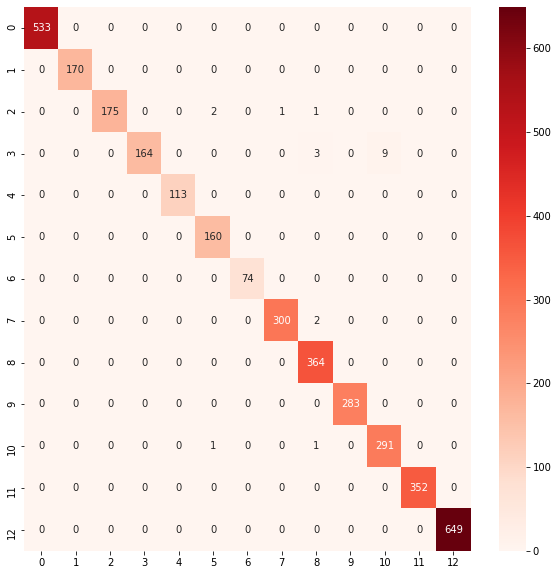

In [ ]:
oa = accuracy_score(np.argmax(ytest, axis=1), newpredtest)
confusion = confusion_matrix(np.argmax(ytest, axis=1), newpredtest)
each_acc, aa = AA_andEachClassAccuracy(confusion)
kappa = cohen_kappa_score(np.argmax(ytest, axis=1), newpredtest)
score = model.evaluate(Xtest, ytest, batch_size=36)
Test_Loss =  score[0]*100
Test_accuracy = score[1]*100
print(oa)
print(kappa)
print(aa)
#print (confusion)
a=confusion.diagonal()/confusion.sum(axis=0)
print(a)

plt.figure(figsize=(10,10))
sn.heatmap(confusion, annot=True, cmap=plt.cm.Reds,fmt="d")
plt.show()

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
dataset = 'KSC'

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/content/drive/MyDrive')
    if name == 'KSC':
        data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
        labels = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']


    return data, labels

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = B

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

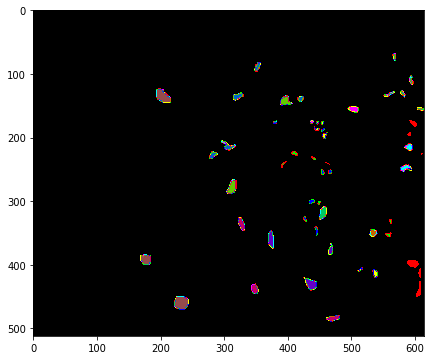

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

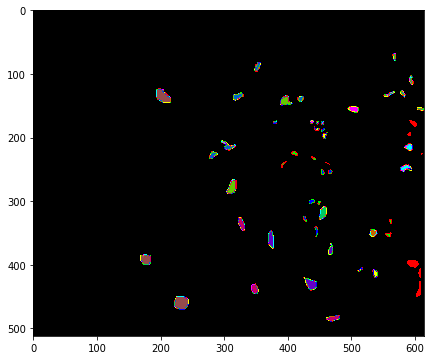

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))